In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

# Load Original Features

In [2]:
feat_num = 469

In [3]:
df_total_raw = pd.read_csv('./data/features%s.csv'%(feat_num))

In [33]:
#to_drop = ['card1_count','addr2','V117','V118','V120','V122','id_25','id_21','id_26',
#           'V305','id_17','V27','V28','V88','V89','id_14','V107','V240','V241','V41','id_24','V68']
to_drop = ['addr2','id_25']

In [34]:
df_total = df_total_raw.drop(to_drop,axis=1)
#df_total = df_total_raw

In [35]:
features_train = df_total[df_total['isFraud'].notnull()]
features_test = df_total[df_total['isFraud'].isnull()]

In [36]:
labels_train = features_train['isFraud']
features_train = features_train.drop(columns = ['isFraud', 'TransactionID'])

In [37]:
features_train.shape

(590540, 465)

# Prepare model

In [38]:
categorical = ['ProductCD', 'card2', 'card3', 'card4', 'card5','card6',
              'addr1','addr2','P_email','R_email','M1','M2','M3',
              'M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo','dow','hour',
              'Device_name','Device_version','screen_width','screen_height',
               'P_email_suffix','R_email_suffix','id_30_OS','id_30_version'] 
ids = [ 'id_%s'%(i) for i in range(12,39)]
categorical = categorical + ids

In [39]:
categorical = list(set(categorical).intersection(df_total.columns))

In [40]:
features_test_new = features_test.drop(columns = ['isFraud', 'TransactionID'])

In [41]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
          #'device' :'gpu'
          #'is_unbalance':True
          #'scale_pos_weight':9
         }

# Feature Selection

In [42]:
features_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,card_D15_mean,card_D15_std,addr1_D15_mean,addr1_D15_std,TransactionAmt_decimal,Device_name,Device_version,is_card_freq_Device,screen_width,screen_height
0,86400,68.5,0,13926,NaN,150.0,0,142.0,0,315.0,...,0.000000,0.000000,0.000000,0.000000,500,-1,-1,False,-1,-1
1,86401,29.0,0,2755,404.0,150.0,1,102.0,0,325.0,...,0.000000,0.000000,0.000000,0.000000,0,-1,-1,False,-1,-1
2,86469,59.0,0,4663,490.0,150.0,2,166.0,1,330.0,...,2.188598,1.578656,1.420777,1.251501,0,-1,-1,False,-1,-1
3,86499,50.0,0,18132,567.0,150.0,1,117.0,1,476.0,...,0.471748,0.434842,0.581165,0.474049,0,-1,-1,False,-1,-1
4,86506,50.0,1,4497,514.0,150.0,1,102.0,0,420.0,...,NaN,NaN,NaN,NaN,0,0,0,False,0,0


In [43]:
train_set = lgb.Dataset(features_train.iloc[0:472432,:], label=labels_train.values[0:472432],categorical_feature=categorical)#
valid_set = lgb.Dataset(features_train.iloc[472432:,:], label=labels_train.values[472432:],categorical_feature=categorical)#
valid_results = {}
model = lgb.train(params,train_set,num_boost_round = 10000, 
                   valid_sets = [train_set, valid_set],
                    verbose_eval=500,
                    early_stopping_rounds = 500,
                 evals_result=valid_results)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987622	valid_1's auc: 0.920788
[1000]	training's auc: 0.998498	valid_1's auc: 0.928451
[1500]	training's auc: 0.999881	valid_1's auc: 0.928805
[2000]	training's auc: 0.999994	valid_1's auc: 0.929334
[2500]	training's auc: 1	valid_1's auc: 0.929744
[3000]	training's auc: 1	valid_1's auc: 0.929794
Early stopping, best iteration is:
[2758]	training's auc: 1	valid_1's auc: 0.929892


In [44]:
max(valid_results['valid_1']['auc'])

0.929892182102943

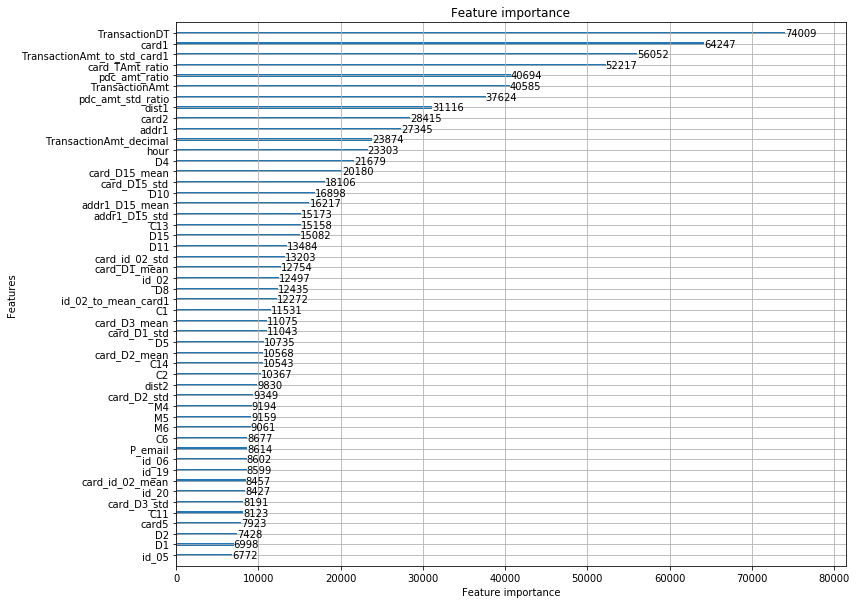

In [45]:
lgb.plot_importance(model, max_num_features=50,figsize=(12,10))

# Train Model

In [46]:
splits = 5
folds = KFold(n_splits = splits,random_state=RSEED)
predictions = np.zeros(len(features_test_new))
ave_auc = 0

In [47]:
for fold_num, (trn_idx, val_idx) in enumerate(folds.split(features_train.values, 
                                                          labels_train.values)):
    print("Fold {}".format(fold_num))
    train_df, y_train_df = features_train.iloc[trn_idx], labels_train.iloc[trn_idx]
    valid_df, y_valid_df = features_train.iloc[val_idx], labels_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df,categorical_feature=categorical)
    val_data = lgb.Dataset(valid_df, label=y_valid_df,categorical_feature=categorical)
    
    valid_results = {}
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500,
                   evals_result=valid_results)
    
    ave_auc += max(valid_results['valid_1']['auc']) / splits
    pred = clf.predict(valid_df)
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    predictions += clf.predict(features_test_new) / splits

Fold 0


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987344	valid_1's auc: 0.90754
[1000]	training's auc: 0.998234	valid_1's auc: 0.918906
[1500]	training's auc: 0.999827	valid_1's auc: 0.921159
[2000]	training's auc: 0.999991	valid_1's auc: 0.922608
[2500]	training's auc: 1	valid_1's auc: 0.923081
[3000]	training's auc: 1	valid_1's auc: 0.923464
[3500]	training's auc: 1	valid_1's auc: 0.923507
Early stopping, best iteration is:
[3281]	training's auc: 1	valid_1's auc: 0.923509
  auc =  0.9235091633448329
Fold 1


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988129	valid_1's auc: 0.929645
[1000]	training's auc: 0.998543	valid_1's auc: 0.936557
[1500]	training's auc: 0.999879	valid_1's auc: 0.937229
Early stopping, best iteration is:
[1440]	training's auc: 0.999835	valid_1's auc: 0.937321
  auc =  0.9373208632728351
Fold 2


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.988969	valid_1's auc: 0.928013
[1000]	training's auc: 0.998612	valid_1's auc: 0.9332
[1500]	training's auc: 0.999887	valid_1's auc: 0.933425
Early stopping, best iteration is:
[1444]	training's auc: 0.999849	valid_1's auc: 0.933494
  auc =  0.933494220358744
Fold 3


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.98827	valid_1's auc: 0.944652
[1000]	training's auc: 0.998605	valid_1's auc: 0.951774
[1500]	training's auc: 0.999889	valid_1's auc: 0.952546
Early stopping, best iteration is:
[1425]	training's auc: 0.999834	valid_1's auc: 0.952616
  auc =  0.9526164048291492
Fold 4


/home/jinpwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1247: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.987622	valid_1's auc: 0.920788
[1000]	training's auc: 0.998498	valid_1's auc: 0.928451
[1500]	training's auc: 0.999881	valid_1's auc: 0.928805
[2000]	training's auc: 0.999994	valid_1's auc: 0.929334
[2500]	training's auc: 1	valid_1's auc: 0.929744
[3000]	training's auc: 1	valid_1's auc: 0.929794
Early stopping, best iteration is:
[2758]	training's auc: 1	valid_1's auc: 0.929892
  auc =  0.9298921821029431


In [106]:
ave_auc

0.9352624272696881

In [32]:
ave_auc

0.9354672457640398

In [38]:
id_test = features_test['TransactionID']
submission = pd.DataFrame({'TransactionID': id_test, 
                            'isFraud': predictions})
submission.to_csv('./data/sub_feat%s_rm1_modelselect.csv'%(feat_num), index = False)